<a href="https://colab.research.google.com/github/UlyShel/basics_of_machine_learning/blob/main/HW7_Shelegova_Ulyana_%D0%9E%D0%9C%D0%9E2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:
def entropy(tree):
  tree_new = tree.value_counts().values / len(tree)
  entr = -np.sum(tree_new * np.log2(tree_new))
  return np.round(entr, 2)

tree = pd.DataFrame(np.array([*[0]*8, *[1]*2]))
entropy(tree)

0.72

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:
left = np.array([*[0]*8])
right = np.array([*[1]*2])

def index_gini(tree):
  tree = pd.DataFrame(tree)
  counts = tree.value_counts().values
  total_count = len(tree)
  if total_count != 0:
    p = counts / total_count
    return np.round(np.sum(p * (1 - p)), 2)
  else:
    return 0

# сразу пишу дисперсию для 2.1
def dispercy(tree):
  if len(tree) != 0:
    yr = (1/len(tree)) * np.sum(tree)
    hr = (1 / len(tree)) * np.sum((tree - yr)**2)
    return hr
  else:
    return 0

def criteria_info(tree_initial, left_child, right_child, criteria):
  if criteria == 'gini':
    return index_gini(tree_initial) - (len(left_child)/len(tree_initial) * index_gini(left_child)) - (len(right_child)/len(tree_initial)  * index_gini(right_child))

  # сразу пишу дисперсию для 2.1
  elif criteria == 'dispercy':
    return dispercy(tree_initial) - (len(left_child)/len(tree_initial) * dispercy(left_child)) - (len(right_child)/len(tree_initial) * dispercy(right_child))
  else:
    raise ValueError

criteria_info(tree, left, right, 'gini')

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [ ]:
leaf = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
np.sum(leaf) / len(leaf)

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух соседних (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    feature_vector = np.array(feature_vector)
    target_vector = np.array(target_vector)

    ginis = []

    if feature_type == 'real':
      sorted_indices = np.argsort(feature_vector)
      feature_vector = feature_vector[sorted_indices]
      target_vector = target_vector[sorted_indices]

      thresholds = (feature_vector[1:] + feature_vector[:-1]) / 2

      for threshold in thresholds:
        left_indices = feature_vector <= threshold
        right_indices = feature_vector > threshold

        if len(left_indices) != 0 and len(right_indices) != 0:
          left_tree = target_vector[left_indices]
          right_tree = target_vector[right_indices]

          if task == "classification":
            ginis.append(criteria_info(target_vector, left_tree, right_tree, 'gini'))
          else:
            ginis.append(criteria_info(target_vector, left_tree, right_tree, 'dispercy'))

        else:
          continue

    elif feature_type == "categorical":

        thresholds = np.unique(feature_vector)

        for value in thresholds:
            left_indices = feature_vector == value
            right_indices = feature_vector != value

            if len(left_indices) != 0 and len(right_indices) != 0:
                left_tree = target_vector[left_indices]
                right_tree = target_vector[right_indices]

                if task == "classification":
                    ginis.append(criteria_info(target_vector, left_tree, right_tree, 'gini'))
                else:
                    ginis.append(criteria_info(target_vector, left_tree, right_tree, 'dispercy'))
            else:
                continue


    gini_best = np.max(ginis)
    threshold_best = thresholds[np.argmax(ginis)]

    return thresholds, np.array(ginis), threshold_best, gini_best

Эту функцию можно протестировать на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

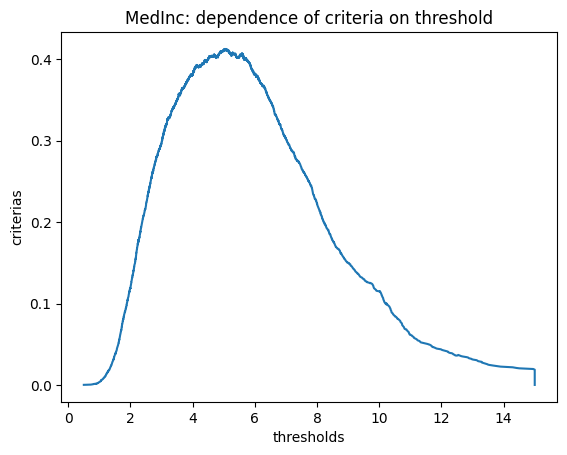

In [ ]:
thres = find_best_split(X['MedInc'], y, 'regression', 'real')[0]
gini = find_best_split(X['MedInc'], y, 'regression', 'real')[1]
plt.plot(thres, gini)
plt.xlabel('thresholds')
plt.ylabel('criterias')
plt.title('MedInc: dependencе of criteria on threshold');

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [ ]:
for name in X.columns:
  print(f"{name}: {find_best_split(X[name], y, 'regression', 'real')[3]}") # лучший - MedInc, с ним критерий информативности наибольший!

MedInc: 0.41275138620167656
HouseAge: 0.030900940598321186
AveRooms: 0.15920795258922488
AveBedrms: 0.01525341559594362
Population: 0.0028306480479909357
AveOccup: 0.07391870577793286
Latitude: 0.09033408765372021
Longitude: 0.05021105203303022


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова

        if np.all(sub_y == sub_y[0]):
          node["type"] = "terminal"
          node["class"] = sub_y[0]
          return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]

                # заменяю пропуски средним
                feature_vector = np.where(np.isnan(feature_vector),feature_vector.mean(), feature_vector)

            elif feature_type == "categorical":

                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X.iloc[:, feature]

                # выделим в отдельную пустую категорию пропущенные значения
                feature_vector = np.where(np.isnan(feature_vector), "", feature_vector)

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # добавляю в словарь значение критерия информативности, который соответствует признаку, чтобы потом отсортировать важность признаков позже
                self._feature_importances[feature] = gini_best

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}

        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
          return node['class']

        else:

          if self._feature_types[node['feature_split']] == 'real':
            if x[node['feature_split']] <= node['threshold']:
              return self._predict_node(x, node['left_child'])
            else:
              return self._predict_node(x, node["right_child"])
          elif self._feature_types[node['feature_split']] == 'categorical':
            if x[node['feature_split']] == node['category_split']:
              return self._predict_node(x, node['left_child'])
            else:
              return self._predict_node(x, node['right_child'])
          else:
            raise ValueError

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

NameError: name 'Union' is not defined

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
!wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/students.csv

--2024-05-27 13:19:41--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/students.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7794 (7.6K) [text/plain]
Saving to: ‘students.csv.4’

students.csv.4      100%[===================>]   7.61K  --.-KB/s    in 0s      

2024-05-27 13:19:41 (67.2 MB/s) - ‘students.csv.4’ saved [7794/7794]



In [ ]:
df = pd.read_csv("/content/students.csv")
df.drop('Unnamed: 0', axis=1)

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,1
254,0.78,0.61,0.71,0.19,0.60,1
255,0.54,0.82,0.71,0.29,0.77,1
256,0.50,0.75,0.81,0.61,0.26,1


In [ ]:
thresholds_STG = find_best_split(df['STG'], df['UNS'], 'classification', 'real')[0]
ginis_STG = find_best_split(df['STG'], df['UNS'], 'classification', 'real')[1]

In [ ]:
thresholds_SCG = find_best_split(df['SCG'], df['UNS'], 'classification', 'real')[0]
ginis_SCG = find_best_split(df['SCG'], df['UNS'], 'classification', 'real')[1]

In [ ]:
thresholds_STR = find_best_split(df['STR'], df['UNS'], 'classification', 'real')[0]
ginis_STR = find_best_split(df['STR'], df['UNS'], 'classification', 'real')[1]

In [ ]:
thresholds_LPR = find_best_split(df['LPR'], df['UNS'], 'classification', 'real')[0]
ginis_LPR = find_best_split(df['LPR'], df['UNS'], 'classification', 'real')[1]

In [ ]:
thresholds_PEG = find_best_split(df['PEG'], df['UNS'], 'classification', 'real')[0]
ginis_PEG = find_best_split(df['PEG'], df['UNS'], 'classification', 'real')[1]

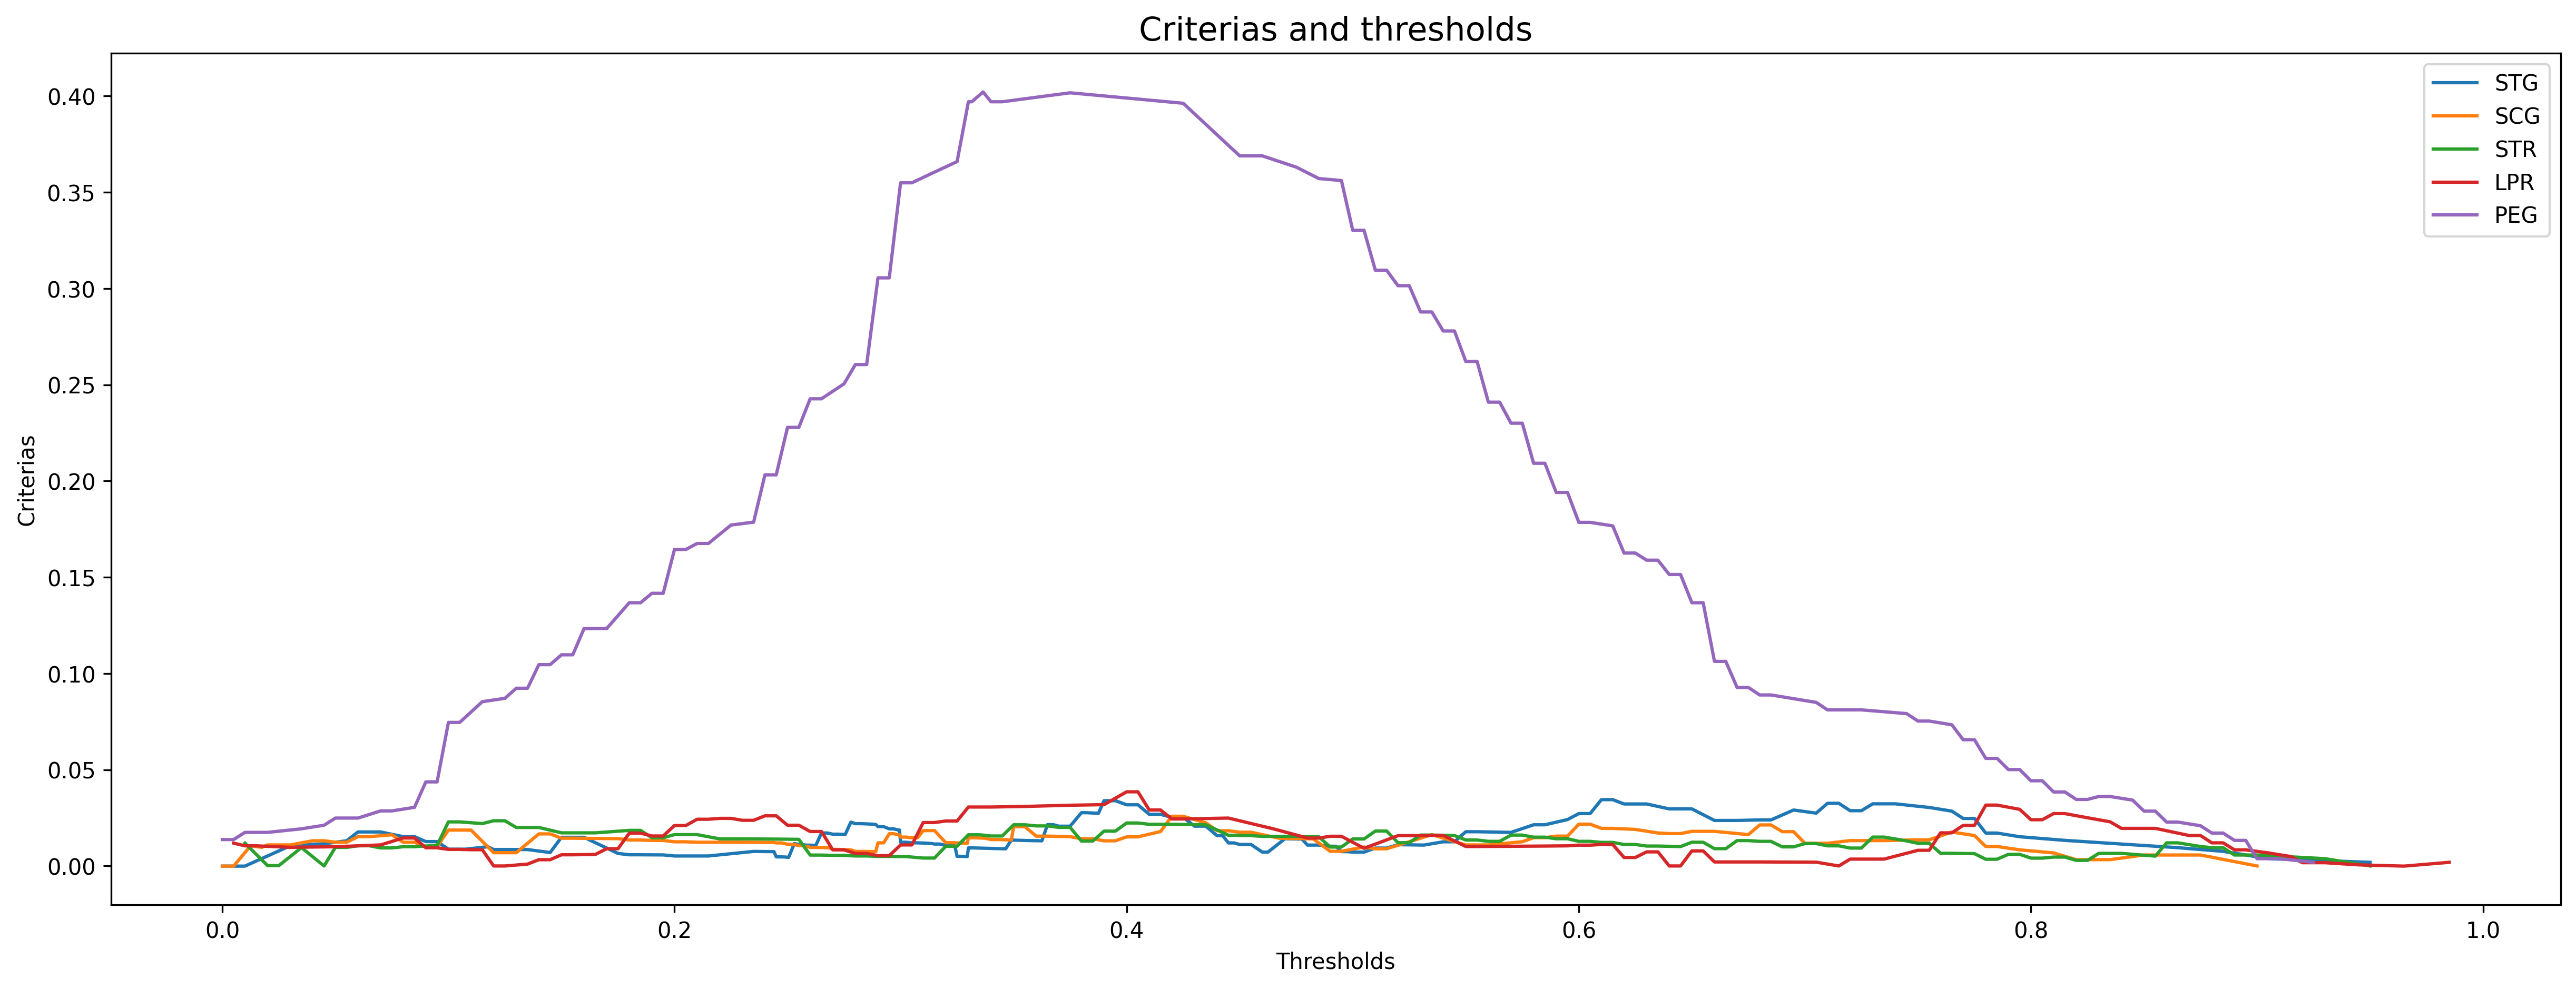

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7), dpi=300)

ax.plot(thresholds_STG, ginis_STG, label='STG')
ax.plot(thresholds_SCG, ginis_SCG, label='SCG')
ax.plot(thresholds_STR, ginis_STR, label='STR')
ax.plot(thresholds_LPR, ginis_LPR, label='LPR')
ax.plot(thresholds_PEG, ginis_PEG, label='PEG')

ax.set_title('Criterias and thresholds', fontsize=15)
ax.set_xlabel('Thresholds')
ax.set_ylabel('Criterias')

ax.legend()

plt.show()

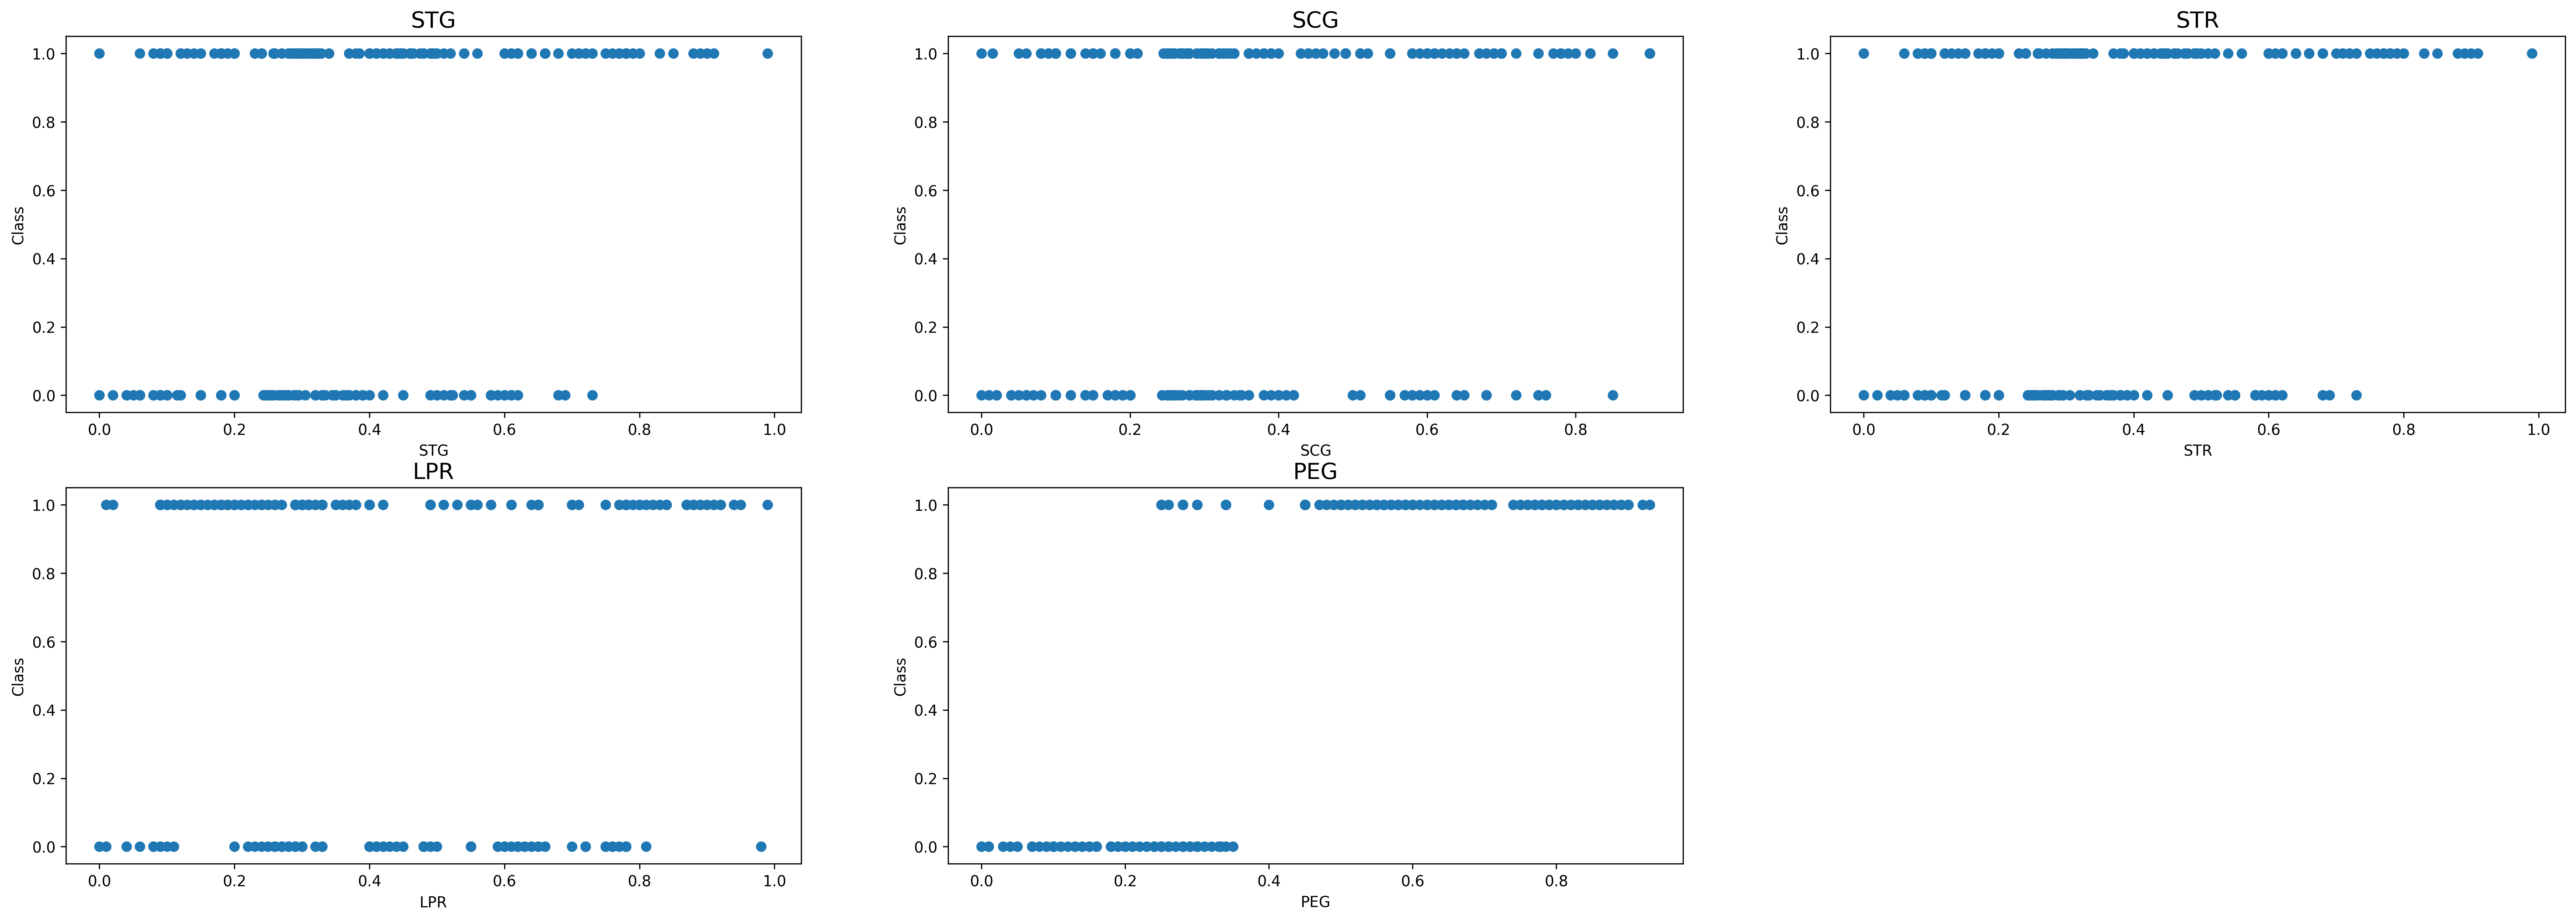

In [ ]:
fig = plt.figure(figsize=(30, 10), dpi=300)

ax1 = plt.subplot(2, 3, 1)

ax1.scatter(df['STG'], df['UNS'])
ax1.set_title('STG', fontsize=15)
plt.xlabel('STG')
plt.ylabel('Class')

ax2 = plt.subplot(2, 3, 2)

ax2.scatter(df['SCG'], df['UNS'])
ax2.set_title('SCG', fontsize=15)
plt.xlabel('SCG')
plt.ylabel('Class')

ax3 = plt.subplot(2, 3, 3)

ax3.scatter(df['STG'], df['UNS'])
ax3.set_title('STR', fontsize=15)
plt.xlabel('STR')
plt.ylabel('Class')

ax4 = plt.subplot(2, 3, 4)

ax4.scatter(df['LPR'], df['UNS'])
ax4.set_title('LPR', fontsize=15)
plt.xlabel('LPR')
plt.ylabel('Class')

ax5 = plt.subplot(2, 3, 5)

ax5.scatter(df['PEG'], df['UNS'])
ax5.set_title('PEG', fontsize=15)
plt.xlabel('PEG')
plt.ylabel('Class');

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Стоит делить, исходя из признака Peg (оценка на экзамене на goal дисциплинах), потому что в этом случае при пороге примерно 0.37, получится добить самого большого критерия информативности среди всех признаков. Это так же сошгласуется с диаграммой рассеивания, потому что именно этот критерий позволяет разделить выборку на две примерно равные части (до 0.37 - класс 0, после - класс 1).

Кривая для признака Peg имеет вид парабалоида с четко заметной очкой максимума, которую можно выделить длявычисления оптимального порога, графики же других признаков выглядят очень смешано и спорно, точки максимума не особо заметны, и это соотносится и с диаграммами рассивания (классы перемешаны, нельзя выбрать подходящий порог, который хоть как-то адекватно разделят выборку).

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

mushroom = fetch_ucirepo(id=73)

X = mushroom.data.features
y = mushroom.data.targets

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
X_mushroom = pd.DataFrame()
le = LabelEncoder()
for i in range(X.shape[1]):
  le.fit(X.iloc[:, i])
  le_res = le.transform(X.iloc[:, i])
  X_mushroom[X.columns[i]] = le_res

In [ ]:
le.fit(y)
le_res = le.transform(y)
y_mushroom = pd.DataFrame(le_res, columns=y.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
from sklearn.model_selection import train_test_split

np.random.seed(66)
X_train, X_test, y_train, y_test = train_test_split(X_mushroom, y_mushroom, test_size=0.5)

In [ ]:
dt = DecisionTree(['categorical'] * X_train.shape[1])
dt.fit(X_train, np.array(y_train))

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, dt.predict(X_test.values))

0.6493506493506493

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
!wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/diabetes.csv
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

--2024-05-27 10:17:55--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23105 (23K) [text/plain]
Saving to: ‘diabetes.csv’

diabetes.csv        100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2024-05-27 10:17:55 (17.0 MB/s) - ‘diabetes.csv’ saved [23105/23105]

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

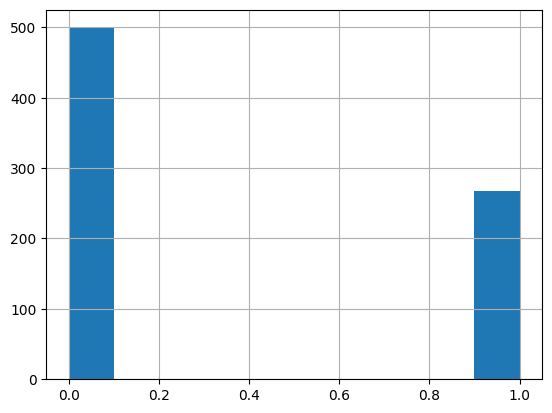

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
y_data = data['Outcome']
X_data = data.drop('Outcome', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=66, stratify=y_data)

In [ ]:
X_train_res, X_val, y_train_res, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state=66, stratify=y_train)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [ ]:
depths = [1, 3, 5, 7, 9]
leaves = [1, 3, 5, 7, 9]

df_leaf_depth = pd.DataFrame(columns=['Depth', 'Leaf', 'F-1 score'])

for depth in depths:
  for leaf in leaves:
    dt = DecisionTreeClassifier(max_depth = depth, min_samples_leaf=leaf)
    dt.fit(X_train_res, y_train_res)
    y_val_predicted = dt.predict(X_val)
    df_leaf_depth.loc[len(df_leaf_depth.index)] = [depth, leaf, f1_score(y_val, y_val_predicted)]

df_leaf_depth.sort_values(by='F-1 score')
 # лучшим оказалось дерево с глубиной 5 и минимальным количеством листьев 7

,Depth,Leaf,F-1 score
22,9.0,5.0,0.453608
21,9.0,3.0,0.456522
17,7.0,5.0,0.474227
4,1.0,9.0,0.482759
0,1.0,1.0,0.482759
2,1.0,5.0,0.482759
1,1.0,3.0,0.482759
3,1.0,7.0,0.482759
5,3.0,1.0,0.494118
6,3.0,3.0,0.494118


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [ ]:
dt = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 7)
dt.fit(X_train_res, y_train_res)
y_test_predicted = dt.predict(X_test)
print(classification_report(y_test, y_test_predicted)) #довольно неплохое качество!! правда меня смущает полнота хуже у 1 класса значительно хуже, чем у 0, возможно, это связано с дисалансом классов.. хотя я пыталась это учесть с помощью стратифая

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       150
           1       0.65      0.57      0.61        81

    accuracy                           0.74       231
   macro avg       0.71      0.70      0.71       231
weighted avg       0.73      0.74      0.74       231



In [ ]:
y_test.value_counts() #да, классов действительно очень разное количество..

Outcome
0    150
1     81
Name: count, dtype: int64

In [ ]:
y_data.value_counts() #даже в исходной выборке))

Outcome
0    500
1    268
Name: count, dtype: int64

In [ ]:
roc_auc_score(y_test, y_test_predicted) #тем не менее, даже не смотря на "пробел" в данных, качество довольно неплохое

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
bagging_classifier = BaggingClassifier(estimator=dt, n_estimators=10, random_state=66)
bagging_classifier.fit(X_train, y_train)

y_test_bagging = bagging_classifier.predict(X_test)

print(classification_report(y_test, y_test_bagging))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       150
           1       0.71      0.60      0.65        81

    accuracy                           0.77       231
   macro avg       0.76      0.74      0.74       231
weighted avg       0.77      0.77      0.77       231



In [ ]:
roc_auc_score(y_test, y_test_bagging) #качество улучшилось!!!

0.7358024691358025

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
depth_rf = [20, 40, 60, 80, 100]
min_samples_rf = [2, 3, 5, 7, 9]

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_df = pd.DataFrame(columns=['Depth', 'Leaf', 'F1-score'])
for depth in depth_rf:
  for sample in min_samples_rf:
    rf = RandomForestClassifier(n_estimators=50, max_depth = depth, min_samples_split = sample)
    scores = cross_val_score(rf, X_train, y_train, cv=3, scoring='f1', error_score='raise')
    rf_df.loc[len(rf_df.index)] = [depth, sample, scores.mean()] #https://www.excelguide.ru/2021/10/add-row-pandas.html

rf_df.sort_values(by='F1-score')

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
# https://education.yandex.ru/handbook/ml/article/kross-validaciya
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

,Depth,Leaf,F1-score
20,100.0,2.0,0.570480
6,40.0,3.0,0.577443
4,20.0,9.0,0.578389
22,100.0,5.0,0.579890
12,60.0,5.0,0.581082
17,80.0,5.0,0.583565
5,40.0,2.0,0.585292
8,40.0,7.0,0.585709
11,60.0,3.0,0.585813
23,100.0,7.0,0.588177


In [ ]:
rf = RandomForestClassifier(max_depth = 60, min_samples_leaf=9)
rf.fit(X_train, y_train)
y_test_rf = rf.predict(X_test)

print(classification_report(y_test, y_test_rf))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       150
           1       0.71      0.65      0.68        81

    accuracy                           0.78       231
   macro avg       0.76      0.75      0.76       231
weighted avg       0.78      0.78      0.78       231



In [ ]:
roc_auc_score(y_test, y_test_rf) # качество еще больше выросло, и эта модель оказалась самой лучшей

0.7538271604938271

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [ ]:
roc_auc = pd.DataFrame(columns=['trees number', 'auc-roc'])
n_trees = [10, 30, 50, 100, 150, 200, 250, 500, 1000]
for number in n_trees:
  rf = RandomForestClassifier(n_estimators = number, max_depth = 60, min_samples_leaf=9)
  rf.fit(X_train, y_train)
  y_predicted = rf.predict(X_test)
  roc_auc.loc[len(roc_auc.index)] = [number, roc_auc_score(y_test, y_predicted)]

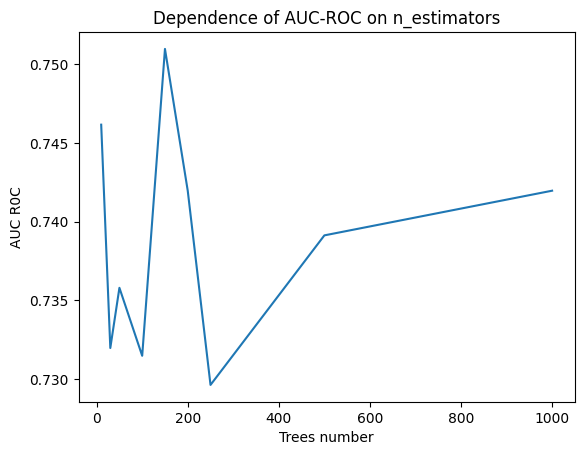

In [ ]:
x = roc_auc['trees number']
y = roc_auc['auc-roc']
plt.plot(x, y)
plt.xlabel('Trees number')
plt.ylabel('AUC R0C')
plt.title('Dependence of AUC-ROC on n_estimators');

In [ ]:
roc_auc.sort_values(by='auc-roc')

,trees number,auc-roc
6,250.0,0.729630
3,100.0,0.731481
1,30.0,0.731975
2,50.0,0.735802
7,500.0,0.739136
5,200.0,0.741975
8,1000.0,0.741975
0,10.0,0.746173
4,150.0,0.750988


AUC ROC принимает наибольшее значение на числе деревьев равном 50 (0.77), дальше площадь уменьшается и вновь растет, но такой величины уже не достигает, что на самом деле удивительно, учитывая то, что на лекции нам говорили, что число деревьев можно подбирать, но можно поставить и очень большое, потому что случайный лес не переобучается. Ради справедливости разница между 1000 и 50 в значении AUC ROC действительно небольшая, всего 0.03, поэтому в целом подбирать число деревьев необязательно очень старательно. Тем не менее, возможно, на позитивный результат повлиял именно подбор других гиперпараметров через кросс-валидацию (глубина и минимальное количество листьев), а потому пренебрегать чем-либо не стоит

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [ ]:
feat_importance = pd.DataFrame(columns=['Feature', 'Importance'])
for feature, importance in zip(X_data.columns, rf.feature_importances_):
    feat_importance.loc[len(feat_importance)] = [feature, importance]

# https://habr.com/ru/companies/ruvds/articles/488342/

In [ ]:
import seaborn as sns

<ipython-input-337-76dbec230426>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_importance.sort_values(by='Importance'), x='Feature', y='Importance', palette='husl', capsize=2)


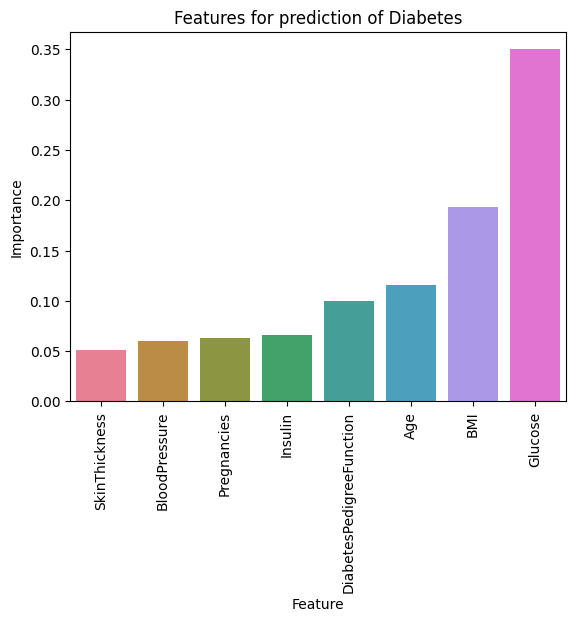

In [ ]:
sns.barplot(data=feat_importance.sort_values(by='Importance'), x='Feature', y='Importance', palette='husl', capsize=2)
plt.xticks(rotation=90)
plt.title('Features for prediction of Diabetes', fontsize='large')
plt.show()

Самым важным оказалась глюкоза (т.е. концентрация глюкозы в плазме крови через 2 часа при пероральном тесте на толерантность к глюкозе).